In [144]:
import torch
from torch import nn

In [145]:
target_a = 5.
target_b = 9.
target_c = 62.

In [146]:
tran_splite_rate = .8
X = torch.arange(start=-100, end=100, step=1, dtype=torch.float).unsqueeze(1)
tran_splite = int(tran_splite_rate * len(X))
Y = target_a*(X**2) + target_b*X + target_c
X, Y
X_train, X_test = X[:tran_splite], X[tran_splite:]
Y_train, Y_test = Y[:tran_splite], Y[tran_splite:]

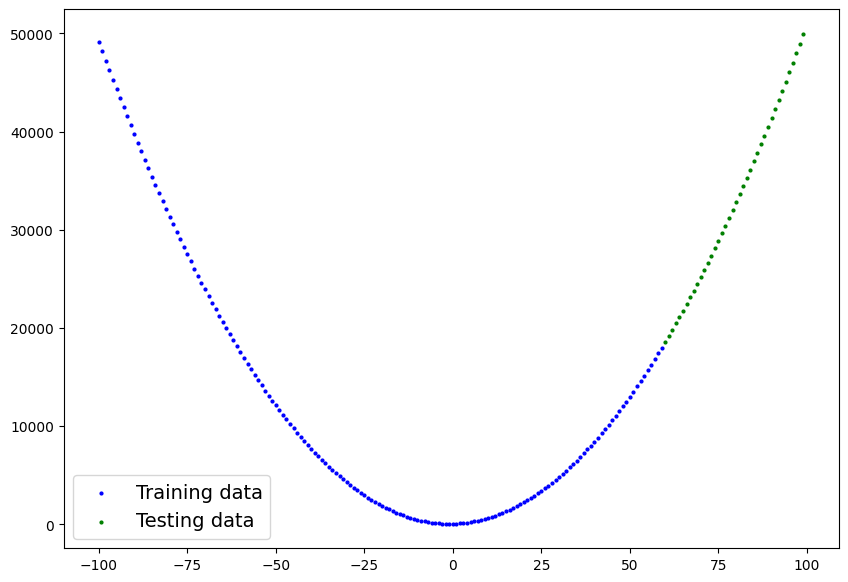

In [147]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train, 
                     train_labels=Y_train, 
                     test_data=X_test, 
                     test_labels=Y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14})

plot_predictions()

In [148]:


class MOD(nn.Module):
    def __init__(self):
        super().__init__()
        self.a = nn.Parameter(torch.rand(size=[1], dtype=torch.float),requires_grad=True)
        self.b = nn.Parameter(torch.rand (size=[1], dtype=torch.float),requires_grad=True)
        self.c = nn.Parameter(torch.rand (size=[1], dtype=torch.float),requires_grad=True)

    def forward(self, _X : torch.Tensor):
        return (self.a*(_X**2)) + (self.b*_X) + self.c
    
torch.manual_seed(96995416)
mod = MOD()
list(mod.parameters())

[Parameter containing:
 tensor([0.6588], requires_grad=True),
 Parameter containing:
 tensor([0.8220], requires_grad=True),
 Parameter containing:
 tensor([0.2678], requires_grad=True)]

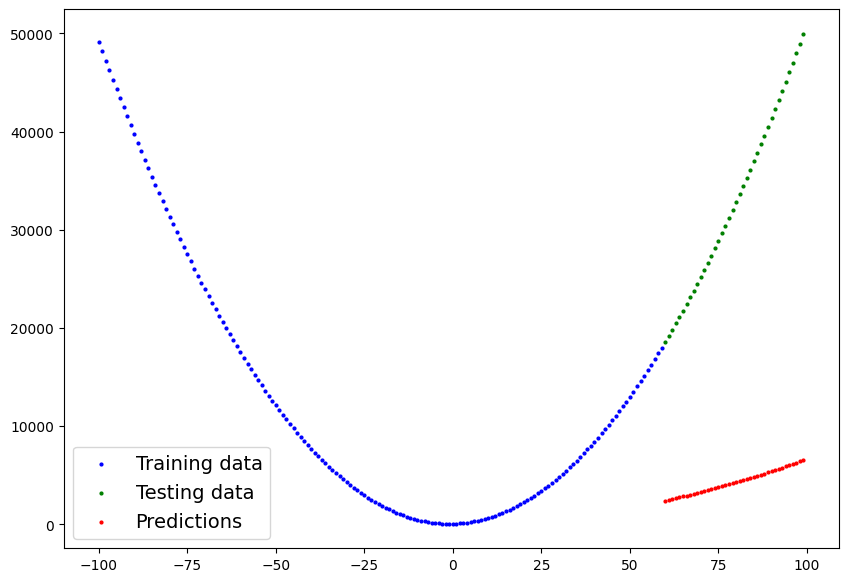

In [149]:
with torch.inference_mode():
    plot_predictions(predictions=mod(X_test))

In [150]:

# GPU计算
mod = mod.cuda()
X_train, Y_train, X_test, Y_test = [x.cuda() for x in [X_train, Y_train, X_test, Y_test]]

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(params=mod.parameters(), lr=0.001)

epochs = 100000

epoch_count = []
train_loss_values = []
test_loss_values = []


for epoch in range(epochs):
    # 设置模型为训练模式
    mod.train()
    # 推理
    y_pred = mod(X_train)
    # 计算损失
    loss = loss_fn(y_pred, Y_train)
    # 梯度置零
    optimizer.zero_grad()
    # 反向传播计算梯度
    loss.backward()
    # 执行优化器
    optimizer.step()
    # 设置模型为评估模式
    mod.eval()
    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = mod(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, Y_test) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 5000 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().cpu().numpy())
            test_loss_values.append(test_loss.detach().cpu().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 250660480.0 | MAE Test Loss: 890151040.0 
Epoch: 5000 | MAE Train Loss: 4009282.5 | MAE Test Loss: 27835054.0 
Epoch: 10000 | MAE Train Loss: 140018.171875 | MAE Test Loss: 2523960.75 
Epoch: 15000 | MAE Train Loss: 54599.37109375 | MAE Test Loss: 929186.9375 
Epoch: 20000 | MAE Train Loss: 9368.1123046875 | MAE Test Loss: 122453.625 
Epoch: 25000 | MAE Train Loss: 1012.4859619140625 | MAE Test Loss: 1175.978759765625 
Epoch: 30000 | MAE Train Loss: 801.5007934570312 | MAE Test Loss: 1682.569580078125 
Epoch: 35000 | MAE Train Loss: 618.4583129882812 | MAE Test Loss: 1299.2406005859375 
Epoch: 40000 | MAE Train Loss: 459.61383056640625 | MAE Test Loss: 973.7644653320312 
Epoch: 45000 | MAE Train Loss: 324.8688049316406 | MAE Test Loss: 682.0982055664062 
Epoch: 50000 | MAE Train Loss: 214.1850128173828 | MAE Test Loss: 445.6429138183594 
Epoch: 55000 | MAE Train Loss: 127.24029541015625 | MAE Test Loss: 263.5606994628906 
Epoch: 60000 | MAE Train Loss: 63.732

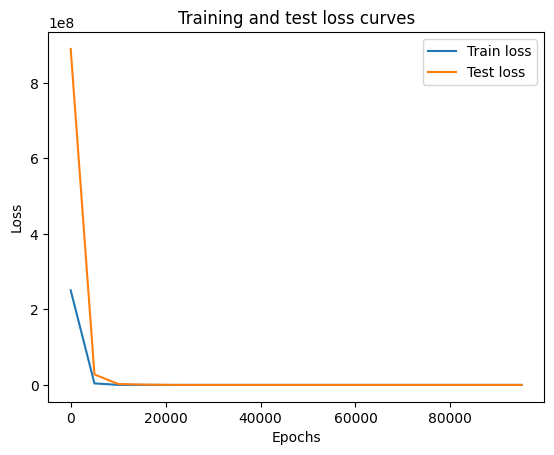

In [151]:
# 绘制学习曲线
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

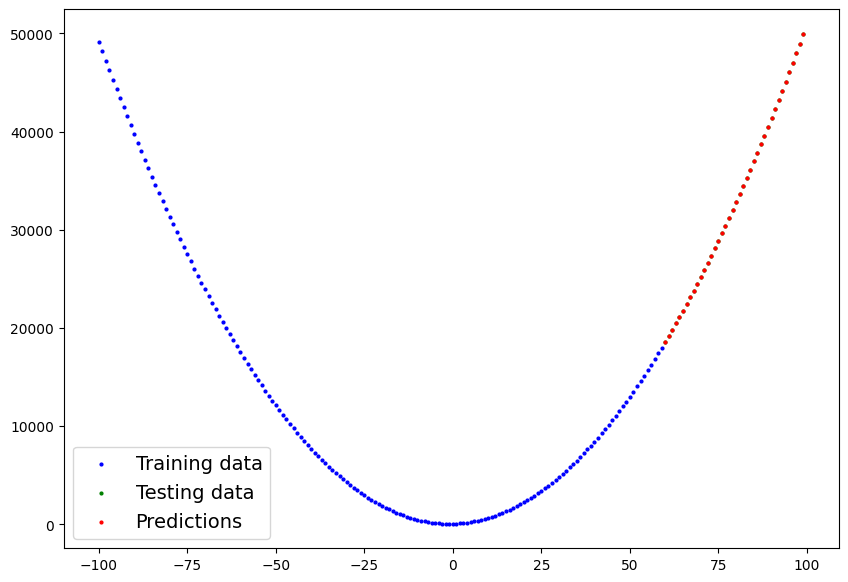

In [153]:
with torch.inference_mode():
    y_pred = mod(X_test).cpu()
plot_predictions(predictions=y_pred)

In [158]:
mod.state_dict(), (target_a, target_b, target_c)

(OrderedDict([('a', tensor([5.], device='cuda:0')),
              ('b', tensor([9.0000], device='cuda:0')),
              ('c', tensor([62.0000], device='cuda:0'))]),
 (5.0, 9.0, 62.0))